# Team Assignment - Intentionally Blank

The following libraries should be installed before proceeding further:
- pandas
- numpy

In [102]:
#Import all necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In addition to the available datasets from the team assignment the original dataset is read for additional information about each ride. The additional information contains the geographical coordinates for the start position and the end position of each ride.

In [103]:
# Reading in weather and philadelphia_2017 data
df_weather = pd.read_csv("data/weather_hourly_philadelphia.csv")
df_philadelphia_2017 = pd.read_csv("data/philadelphia_2017.csv")

# Additionally read the philadelphia data from the official website
data_philadelphia_2017_Q1 = pd.read_csv("data/indego_Q1_2017.csv")
data_philadelphia_2017_Q2 = pd.read_csv("data/indego_Q2_2017.csv")
data_philadelphia_2017_Q3 = pd.read_csv("data/indego_Q3_2017.csv")
data_philadelphia_2017_Q4 = pd.read_csv("data/indego_Q4_2017.csv")

## Preparing and cleaning data

### Preparing and cleaning the philadelphia datasets

In [104]:
# Concatenate all quarters of philadelphia data and convert them to a dataframe
df_philadelphia_website = pd.concat([data_philadelphia_2017_Q1, data_philadelphia_2017_Q2, data_philadelphia_2017_Q3, data_philadelphia_2017_Q4], ignore_index=True)

In [105]:
# Dropping the columns duration, start_station_id, end_station_id, plan_duration, trip_route_category, passholder_type, start_station, end_station
df_philadelphia_website.drop(['duration', 'start_station_id', 'end_station_id', 'plan_duration', 'trip_route_category', 'passholder_type', 'start_station', 'end_station', 'trip_id'], axis=1, inplace=True)
df_philadelphia_website

#Changing the type of start_time, end_time (df_philadelphia_2017 and df_philadelphia_website) and date_time (df_weather) to datetime type from pandas
df_philadelphia_website.loc[:,'start_time'] = pd.to_datetime(df_philadelphia_website['start_time'])
df_philadelphia_website.loc[:,'end_time'] = pd.to_datetime(df_philadelphia_website['end_time'])

df_philadelphia_2017.loc[:,'start_time'] = pd.to_datetime(df_philadelphia_2017['start_time'])
df_philadelphia_2017.loc[:,"end_time"] = pd.to_datetime(df_philadelphia_2017["end_time"])

#Sort dataframes by their corresponding time column
df_philadelphia_website.sort_values(["start_time"], inplace = True)
df_philadelphia_2017.sort_values(["start_time"], inplace = True)


#Resetting the indexes
df_philadelphia_website.reset_index(drop = True, inplace = True)
df_philadelphia_2017.reset_index(drop = True, inplace = True)

Before we further clean the dataset for philadelphia its important to mention that we first deleted the irrelevant stations because some duplicate rows happen to have the same start time, end time and bike ids but different start and end stations like the "Virtual Station". Therefore we deleted those stations first to avoid deleting useful records. In the following example you can see that deleting the duplicates first could lead to deleting useful records and keeping irrelevant records which are deleted either way later.

In [106]:
df_philadelphia_2017[df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id'], keep=False)].head(6)

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name
255753,2017-06-05 15:26:00,2017-06-05 15:27:00,3152,3152,11907,Indego30,"40th & Baltimore, Trolley Portal","40th & Baltimore, Trolley Portal"
255755,2017-06-05 15:26:00,2017-06-05 15:27:00,3000,3000,11907,Indego30,Virtual Station,Virtual Station
256143,2017-06-05 17:26:00,2017-06-05 17:31:00,3152,3024,11907,Walk-up,"40th & Baltimore, Trolley Portal","43rd & Chester, Clark Park"
256148,2017-06-05 17:26:00,2017-06-05 17:31:00,3000,3024,11907,Walk-up,Virtual Station,"43rd & Chester, Clark Park"
258113,2017-06-06 16:02:00,2017-06-06 16:33:00,3004,3000,5314,Indego30,Municipal Services Building Plaza,Virtual Station
258115,2017-06-06 16:02:00,2017-06-06 16:33:00,3004,3161,5314,Indego30,Municipal Services Building Plaza,30th Street Station East


The "3083" station does not exist as a real station. Furthermore the "Virtual Station" is used by staff to check in or check out a bike remotely for an event or when the bike was not properly checked in or out. Therefore we check the number of rows where one of those stations occur and delete those rows afterwards.

For further information please check the official site about the data and the station table [here](https://www.rideindego.com/about/data/).

In [107]:
print(r'Number of rows in df_philadelphia_2017 with "Virtual Station" and "3083" in the start station or end station: ',
 df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] == "Virtual Station") | (df_philadelphia_2017["end_station_name"] == "Virtual Station") |
  (df_philadelphia_2017["start_station_name"] == "3083") | (df_philadelphia_2017["end_station_name"] == "3083")
  ].shape[0])

Number of rows in df_philadelphia_2017 with "Virtual Station" and "3083" in the start station or end station:  6512


In [108]:
# Deleting "Virtual Station" and "3083" from the start_station_name and end_station_name columns
df_philadelphia_2017 = df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] != "3083") & (df_philadelphia_2017["end_station_name"] != "3083") ]
df_philadelphia_2017 = df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] != "Virtual Station") & (df_philadelphia_2017["end_station_name"] != "Virtual Station") ]

display(df_philadelphia_2017[(df_philadelphia_2017["start_station_name"] == "Virtual Station") | (df_philadelphia_2017["end_station_name"] == "Virtual Station") | (df_philadelphia_2017["start_station_name"] == "3083") | (df_philadelphia_2017["end_station_name"] == "3083")])

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name


The "bike_id" should be unique to one bike. No trip with the same bike_id should start and end on the same time interval. 

In [109]:
#Checking for any duplicates in philadelphia data
print("Number of duplicates in df_philadelphia_2017: ", df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id']).sum())
print("Number of duplicates in df_philadelphia_website: ", df_philadelphia_website.duplicated(subset=['start_time', 'end_time', 'bike_id']).sum())

Number of duplicates in df_philadelphia_2017:  55
Number of duplicates in df_philadelphia_website:  68


In [110]:
#Dropping all duplicates for the philadelphia data depending on the start_time, end_time and bike_id
df_philadelphia_2017.drop_duplicates(subset=["start_time", "end_time", "bike_id"], keep="first", inplace=True)
df_philadelphia_website.drop_duplicates(subset=["start_time", "end_time", "bike_id"], keep="first", inplace=True)

display(df_philadelphia_2017[df_philadelphia_2017.duplicated(subset=['start_time', 'end_time', 'bike_id'])].head(10))
display(df_philadelphia_website[df_philadelphia_website.duplicated(subset=['start_time', 'end_time', 'bike_id'])].head(10))

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name


,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id


In [111]:
# Joining df_philadelphia_2017 with df_philadelphia_full on start_time, end_time, bike_id and dropping duplicate columns
df_philadelphia_2017_joined = df_philadelphia_2017.merge(df_philadelphia_website, on=["start_time", "end_time", "bike_id"], how="left")

df_philadelphia_2017_joined

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793
...,...,...,...,...,...,...,...,...,...,...,...,...
782335,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793
782336,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200
782337,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722
782338,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969


In [112]:
#Checking for missing values in philadelphia data
display(df_philadelphia_2017_joined[df_philadelphia_2017_joined.isnull().any(axis = 1)])

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon
255784,2017-06-06 16:02:00,2017-06-06 16:33:00,3004,3161,5314,Indego30,Municipal Services Building Plaza,30th Street Station East,39.953781,-75.163742,NaN,NaN
613438,2017-10-05 08:35:00,2017-10-05 08:47:00,3111,3107,5306,Indego30,"Parkside & Belmont, Case Building",33rd & Reservoir,NaN,NaN,39.982029,-75.18866
613848,2017-10-05 10:31:00,2017-10-05 10:53:00,3095,3111,5329,Indego30,29th & Diamond,"Parkside & Belmont, Case Building",39.987709,-75.180519,NaN,NaN


In [113]:
df_philadelphia_2017_joined.dropna(inplace = True)	

In [114]:
#Adding hour, month, weekday and trip duration(based on start and end time) to the table
df_philadelphia_2017_joined.loc[:,"trip_duration"] = df_philadelphia_2017_joined["end_time"] - df_philadelphia_2017_joined["start_time"] 
df_philadelphia_2017_joined.loc[:,"date"] = df_philadelphia_2017_joined["start_time"].dt.date
df_philadelphia_2017_joined.loc[:,"month"] = df_philadelphia_2017_joined["start_time"].dt.month
df_philadelphia_2017_joined.loc[:,"week"] = df_philadelphia_2017_joined["start_time"].dt.isocalendar().week
df_philadelphia_2017_joined.loc[:,"weekday"] = df_philadelphia_2017_joined["start_time"].dt.weekday
df_philadelphia_2017_joined.loc[:,"day"] = df_philadelphia_2017_joined["start_time"].dt.day
df_philadelphia_2017_joined.loc[:,"hour"] = df_philadelphia_2017_joined["start_time"].dt.hour
df_philadelphia_2017_joined

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,date,month,week,weekday,day,hour
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460,0 days 00:11:00,2017-01-01,1,52,6,1,0
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:36:00,2017-01-01,1,52,6,1,0
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:35:00,2017-01-01,1,52,6,1,0
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028,0 days 00:12:00,2017-01-01,1,52,6,1,0
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793,0 days 00:08:00,2017-01-01,1,52,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782335,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793,0 days 00:28:00,2017-12-31,12,52,6,31,23
782336,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200,0 days 11:52:00,2017-12-31,12,52,6,31,23
782337,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722,0 days 00:07:00,2017-12-31,12,52,6,31,23
782338,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969,0 days 00:01:00,2017-12-31,12,52,6,31,23


We also remove trips which are shorter than one minute and longer than one day because the bike sharing service does not allow those trips normally.

In [115]:
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] < "0 days 00:01:00"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,date,month,week,weekday,day,hour
699155,2017-11-05 01:35:00,2017-11-05 01:03:00,3118,3111,6694,Indego30,"46th Street Station, MFL","Parkside & Belmont, Case Building",39.958660,-75.213226,39.977791,-75.213226,-1 days +23:28:00,2017-11-05,11,44,6,5,1
699158,2017-11-05 01:39:00,2017-11-05 01:35:00,3066,3066,2551,Indego30,19th & Lombard,19th & Lombard,39.945610,-75.173477,39.945610,-75.173477,-1 days +23:56:00,2017-11-05,11,44,6,5,1
699163,2017-11-05 01:51:00,2017-11-05 01:20:00,3157,3041,11750,Indego30,"8th & Mifflin, Bok Building","Girard Station, MFL",39.925449,-75.159538,39.968491,-75.135460,-1 days +23:29:00,2017-11-05,11,44,6,5,1


In [116]:
df_philadelphia_2017_joined = df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] >= "0 days 00:01:00"]
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] < "0 days 00:01:00"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,date,month,week,weekday,day,hour


In [117]:
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] > "1 days"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,date,month,week,weekday,day,hour
682,2017-01-01 18:19:00,2017-01-03 08:04:00,3072,3125,5354,Walk-up,Front & Carpenter,15th & South,39.934448,-75.145409,39.943909,-75.167351,1 days 13:45:00,2017-01-01,1,52,6,1,18
20987,2017-01-23 15:19:00,2017-01-24 16:14:00,3038,3028,2492,Indego30,The Children's Hospital of Philadelphia (CHOP),4th & Bainbridge,39.947811,-75.194092,39.940609,-75.149582,1 days 00:55:00,2017-01-23,1,4,0,23,15
24873,2017-01-26 17:31:00,2017-01-28 10:00:00,3021,3109,5185,Indego30,18th & JFK,Parkside & Girard,39.953899,-75.169022,39.974861,-75.205238,1 days 16:29:00,2017-01-26,1,4,3,26,17
27216,2017-01-28 15:46:00,2017-01-30 08:01:00,3012,3034,5255,Walk-up,21st & Catharine,11th & Reed,39.942181,-75.177467,39.933151,-75.162483,1 days 16:15:00,2017-01-28,1,4,5,28,15
32762,2017-02-02 09:45:00,2017-02-03 17:59:00,3054,3021,5125,Indego30,Rodin Museum,18th & JFK,39.962502,-75.174202,39.953899,-75.169022,1 days 08:14:00,2017-02-02,2,5,3,2,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
735895,2017-11-25 12:12:00,2017-11-27 07:31:00,3112,3020,11894,Indego30,48th & Spruce,University City Station,39.953732,-75.218246,39.949219,-75.190361,1 days 19:19:00,2017-11-25,11,47,5,25,12
749711,2017-12-02 13:00:00,2017-12-03 14:12:00,3040,3073,11928,Walk-up,17th & Spring Garden,9th & Spring Garden,39.962891,-75.166061,39.961430,-75.152420,1 days 01:12:00,2017-12-02,12,48,5,2,13
763091,2017-12-11 11:46:00,2017-12-12 13:15:00,3018,3037,3367,Indego30,12th & Filbert,Pennsylvania Convention Center,39.952728,-75.159790,39.954239,-75.161377,1 days 01:29:00,2017-12-11,12,50,0,11,11
768955,2017-12-15 19:27:00,2017-12-17 16:32:00,3026,3072,11932,Indego30,2nd & South,Front & Carpenter,39.941380,-75.145638,39.934448,-75.145409,1 days 21:05:00,2017-12-15,12,50,4,15,19


In [118]:
df_philadelphia_2017_joined = df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] <= "1 days"]
df_philadelphia_2017_joined[df_philadelphia_2017_joined["trip_duration"] > "1 days"]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,date,month,week,weekday,day,hour


In [119]:
df_philadelphia_cleaned = df_philadelphia_2017_joined.copy()
df_philadelphia_cleaned

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,start_lat,start_lon,end_lat,end_lon,trip_duration,date,month,week,weekday,day,hour
0,2017-01-01 00:05:00,2017-01-01 00:16:00,3046,3041,5347,Indego30,2nd & Market,"Girard Station, MFL",39.950119,-75.144722,39.968491,-75.135460,0 days 00:11:00,2017-01-01,1,52,6,1,0
1,2017-01-01 00:21:00,2017-01-01 00:57:00,3110,3054,3364,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:36:00,2017-01-01,1,52,6,1,0
2,2017-01-01 00:22:00,2017-01-01 00:57:00,3110,3054,2536,Walk-up,Del. River Trail & Penn St.,Rodin Museum,39.961750,-75.136414,39.962502,-75.174202,0 days 00:35:00,2017-01-01,1,52,6,1,0
3,2017-01-01 00:27:00,2017-01-01 00:39:00,3041,3005,5176,Indego30,"Girard Station, MFL","Welcome Park, NPS",39.968491,-75.135460,39.947330,-75.144028,0 days 00:12:00,2017-01-01,1,52,6,1,0
4,2017-01-01 00:28:00,2017-01-01 00:36:00,3047,3124,5370,Walk-up,"Independence Mall, NPS",Race Street Pier,39.950710,-75.149208,39.952950,-75.139793,0 days 00:08:00,2017-01-01,1,52,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782335,2017-12-31 23:05:00,2017-12-31 23:33:00,3070,3124,3708,Indego30,"Spring Garden Station, MFL",Race Street Pier,39.960621,-75.139832,39.952950,-75.139793,0 days 00:28:00,2017-12-31,12,52,6,31,23
782336,2017-12-31 23:11:00,2018-01-01 11:03:00,3107,3165,5117,Indego30,33rd & Reservoir,24th & Race SRT,39.982029,-75.188660,39.958191,-75.178200,0 days 11:52:00,2017-12-31,12,52,6,31,23
782337,2017-12-31 23:18:00,2017-12-31 23:25:00,3033,3046,11933,Indego30,10th & Chestnut,2nd & Market,39.950050,-75.156723,39.950119,-75.144722,0 days 00:07:00,2017-12-31,12,52,6,31,23
782338,2017-12-31 23:39:00,2017-12-31 23:40:00,3163,3163,6725,Indego30,25th & Locust,25th & Locust,39.949741,-75.180969,39.949741,-75.180969,0 days 00:01:00,2017-12-31,12,52,6,31,23


### Preparing and cleaning the weather dataset

After preparing and cleaning the philadelphia dataset we need to do most of the procedure on the weather dataset.

In [120]:
#Changing the type of date_time (df_weather) to datetime type from pandas
df_weather.loc[:, "date_time"] = pd.to_datetime(df_weather["date_time"])

#Sort the dataframe by their corresponding time column
df_weather.sort_values(["date_time"], inplace = True)

#Reset the index
df_weather.reset_index(drop = True, inplace =True)

First of all we check for duplicate rows in the weather data and delete them if they occur because we do not need multiple rows multiple times.

In [121]:
#Checking for any duplicates in weather data
print("Number of duplicates in df_weather: ", df_weather.duplicated().sum())

Number of duplicates in df_weather:  630


In [122]:
#Dropping all duplicates for the weather data
df_weather.drop_duplicates(subset= ["date_time"],inplace = True)

display(df_weather[df_weather.duplicated()])

,date_time,max_temp,min_temp,precip


We also check for null values in the weather data and delete them. It is important to note that we later add additional rows with null values but with the missing time intervals because we can interpolate them with the interpolate function in pandas.

In [123]:
#Checking for missing values in weather data
display(df_weather[df_weather.isnull().any(axis = 1)])

,date_time,max_temp,min_temp,precip
43785,NaT,NaN,NaN,NaN


In [124]:
df_weather.dropna(inplace = True)

Since the weather data consists of data from the beginning of 2015 until the end of 2019, we want to have as well only the weather data for 2017.

In [125]:
#Selecting data from the beginning of 2017 till the end of 2017
df_weather_2017 = df_weather[(df_weather["date_time"]>= "2017-01-01 00:00:00") & (df_weather["date_time"]< "2018-01-01 00:00:00" )]

In [126]:
#Add missing intervals in the weather data
df_weather_2017.set_index("date_time", inplace = True)
df_weather_2017 = df_weather_2017.resample("H").asfreq()

The minimum temperature and maximum temperature will be interpolated linearly. The precipitation value is interpolated by taking one of the nearest existing values.

In [127]:
# Interpolate missing values in the weather data
df_weather_2017["min_temp"].interpolate(method = "linear", inplace = True)
df_weather_2017["max_temp"].interpolate(method = "linear", inplace = True)
df_weather_2017["precip"].interpolate(method = "pad", inplace = True)
df_weather_2017.reset_index(drop=False, inplace = True)

# Check if null values in the weather data still exist
display(df_weather_2017[df_weather_2017.isnull().any(axis = 1)])
display(df_weather_2017)

,date_time,max_temp,min_temp,precip


,date_time,max_temp,min_temp,precip
0,2017-01-01 00:00:00,6.1,6.1,0.0
1,2017-01-01 01:00:00,6.1,6.1,0.0
2,2017-01-01 02:00:00,6.7,6.7,0.0
3,2017-01-01 03:00:00,7.2,7.2,0.0
4,2017-01-01 04:00:00,7.8,7.8,0.0
...,...,...,...,...
8755,2017-12-31 19:00:00,-8.9,-8.9,0.0
8756,2017-12-31 20:00:00,-8.9,-8.9,0.0
8757,2017-12-31 21:00:00,-9.4,-9.4,0.0
8758,2017-12-31 22:00:00,-10.0,-10.0,0.0


All dataframes for reference:
* **Philadelphia data**
   * *df_philadelphia_cleaned*
* **Weather data**
   * *df_weather_2017*

## Descriptive Analytics

### Temporal Demand Patterns and Seasonality

#### Analysis of Rental during the day

First count the started rentals for each hour of the day for the whole dataset and vizualize it in a histogram.

In [128]:
#Calculate the number of rentals in each hour (accumulated over the year)
df = df_philadelphia_cleaned
df.groupby(["hour"])["hour"].count().reset_index(name="n_rentals_within_hour")

,hour,n_rentals_within_hour
0,0,7657
1,1,4901
2,2,3326
3,3,1630
4,4,1729
5,5,7182
6,6,19860
7,7,40014
8,8,65742
9,9,40390


In [129]:
#Calculate the mean
mean = df.groupby(["hour"])["hour"].count().mean()
mean

32592.708333333332

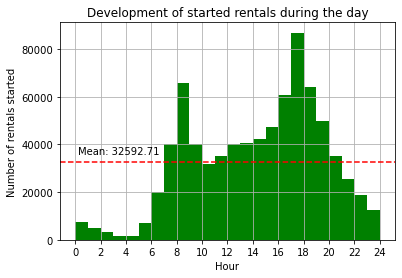

In [130]:
plt.hist(df["hour"], bins=range(0,25,1), color="green")
plt.axhline(mean , color = 'r', linestyle = '--')
plt.xlabel("Hour")
plt.ylabel("Number of rentals started")
plt.title("Development of started rentals during the day")
plt.xticks(range(0,25,2))
plt.grid(True)
min_xlim, max_xlim = plt.xlim()
plt.text(min_xlim*(-0.2), mean*1.1, 'Mean: {:.2f}'.format(mean))
plt.show()

To get average values we calculate the number of days for which we have data in our dataset and calculate the avarage number of rentals started within each hour in a day.

IMPORTANT: The average values only provide meaningful results if we assume that we have all meaningful rental transactions that actually occurred included in our data set or at least equally distributed missing transaction for each hour.

In [131]:
#Check the number of days for which we have data in our set
number_days = len(df["date"].unique())
number_days

365

In [132]:
#Calculate average values for each hour
df_avg_per_hour = df.groupby(["hour"])["hour"].count().divide(number_days).reset_index(name="avg_n_rentals_within_hour")
df_avg_per_hour

,hour,avg_n_rentals_within_hour
0,0,20.978082
1,1,13.427397
2,2,9.112329
3,3,4.465753
4,4,4.736986
5,5,19.676712
6,6,54.410959
7,7,109.627397
8,8,180.115068
9,9,110.657534


In [133]:
#Calculate mean
mean= df_avg_per_hour["avg_n_rentals_within_hour"].mean()
mean

89.29509132420094

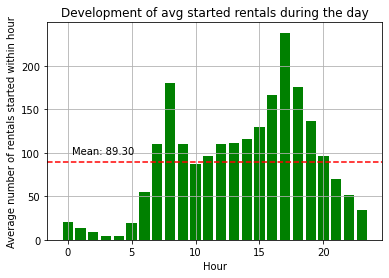

In [134]:
plt.bar(
        df_avg_per_hour["hour"], 
        df_avg_per_hour["avg_n_rentals_within_hour"], 
        color="green"
)
plt.axhline(mean , color = 'r', linestyle = '--')
plt.xlabel("Hour")
plt.ylabel("Average number of rentals started within hour")
plt.title("Development of avg started rentals during the day")
min_xlim, max_xlim = plt.xlim()
plt.text(min_xlim*(-0.2), mean*1.1, 'Mean: {:.2f}'.format(mean))
plt.grid(True)
plt.show()

In the plots above we only considered the starting times of the rentals. To also considere the endtime, we calculate how many bikes in the respective hours were IN USE accumulated over the year. (e.g. rental from 0 o'clock to 2:45 would count as a usage in hour 0, 1 and 2). In the process of calculation we also have to considere that bike rentals can range over two days.

In [135]:
#Calculate average number of bikes in use
df["end_time_hour"] = df["end_time"].dt.hour
df["end_time_date"] = df["end_time"].dt.date
df_values = pd.DataFrame()
for i in range(0,24,1):
    df_values[f"{i}"]= (((df["hour"] <= i) & (df["end_time_hour"] >= i)) 
                        | ((df["end_time_hour"] >= i) & (df["date"] < df["end_time_date"])))

df_sum = df_values.apply(lambda x: x.sum()/number_days).reset_index(name="avg_n_of_bikes_in_use").rename(columns={"index": "hour"})
df_sum

,hour,avg_n_of_bikes_in_use
0,0,34.501370
1,1,22.032877
2,2,15.865753
3,3,9.961644
4,4,9.443836
5,5,24.890411
6,6,63.136986
7,7,125.783562
8,8,211.410959
9,9,149.271233


In [136]:
#Calculate mean
mean = df_sum["avg_n_of_bikes_in_use"].mean()
mean

115.08618721461188

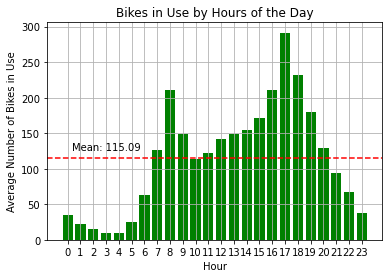

In [137]:
plt.bar(df_sum["hour"], df_sum["avg_n_of_bikes_in_use"], color="green")
plt.axhline(mean , color = 'r', linestyle = '--')
plt.xlabel("Hour")
plt.ylabel("Average Number of Bikes in Use")
plt.title("Bikes in Use by Hours of the Day")
min_xlim, max_xlim = plt.xlim()
plt.text(min_xlim*(-0.2), mean*1.1, 'Mean: {:.2f}'.format(mean))
plt.grid(True)
plt.show()

##### Analysis and Interpretation of the Results:

The plots above all show that we have two peaks of bike rentals in the day. One peak demand at 8 am and the other peak at 5 pm. This peak can be a result of the rush-hour traffic. At these times most people are on their way to work/school or on their way back home. The demand around these times ( 8 am and 5 pm ) are also above average. Besides that, it also becomes clear that the bikes are mostly used during the day. During the night the demand is significantly below average (from 9 pm until 6 am).

#### Analysis of Rental during the week

First count the started rentals for each weekday of the day for the whole dataset and vizualize it in a histogram.

In [138]:
#Calculate accumulated rentals per weekday
df.groupby(["weekday"])["weekday"].count().reset_index(name="n_rentals_within_weekday")

,weekday,n_rentals_within_weekday
0,0,111449
1,1,118958
2,2,128466
3,3,123746
4,4,117736
5,5,91803
6,6,90067


The mapping: {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday",5: "Saturday",6: "Sunday"}

In [139]:
#Calculate mean
mean = df.groupby(["weekday"])["weekday"].count().mean()
mean

111746.42857142857

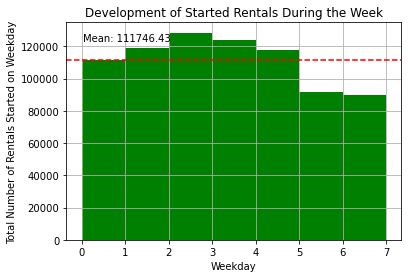

In [140]:
plt.hist(df["weekday"], bins=range(0,8,1), color="green")
plt.axhline(mean , color = 'r', linestyle = '--')
plt.xlabel("Weekday")
plt.ylabel("Total Number of Rentals Started on Weekday")
plt.title("Development of Started Rentals During the Week")
plt.xticks(range(0,8,1))
min_xlim, max_xlim = plt.xlim()
plt.text(min_xlim*(-0.1), mean*1.1, 'Mean: {:.2f}'.format(mean))
plt.grid(True)
plt.show()

To get average values we calculate the number of weeks for which we have data in our dataset and calculate the avarage number of rentals started within each weekday.

IMPORTANT ASSUMPTION: The average values only provide meaningful results if we assume that we have all rental transactions that actually occurred included in our data set or at least equally distributed missing data points for each weekday. Otherwise the average values would provide misleading information. If we for example would have missing rental data for a specific weekday for several weeks, dividing by the total number of weeks would result to false average value for this weekday!

In [141]:
#Check number of weeks we have in our set
number_weeks = len(df["week"].unique())
number_weeks

52

In [142]:
#Calculate average values per weekday
df_average_per_weekday = df.groupby(["weekday"])["weekday"].count().divide(number_weeks).reset_index(name="avg_number_started_rentals")
df_average_per_weekday

,weekday,avg_number_started_rentals
0,0,2143.250000
1,1,2287.653846
2,2,2470.500000
3,3,2379.730769
4,4,2264.153846
5,5,1765.442308
6,6,1732.057692


In [143]:
#Calculate mean
mean = df_average_per_weekday["avg_number_started_rentals"].mean()
mean

2148.96978021978

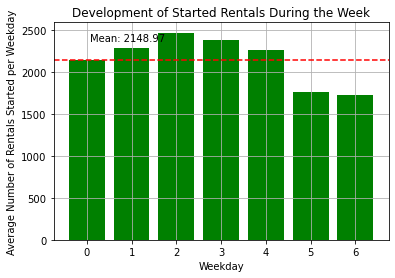

In [144]:
plt.bar(
        df_average_per_weekday["weekday"], 
        df_average_per_weekday["avg_number_started_rentals"], 
        color="green"
)
plt.axhline(mean, color="r", linestyle="--")
plt.xlabel("Weekday")
plt.ylabel("Average Number of Rentals Started per Weekday")
plt.title("Development of Started Rentals During the Week")
min_xlim, max_xlim = plt.xlim()
plt.text(min_xlim*(-0.1), mean*1.1, 'Mean: {:.2f}'.format(mean))
plt.grid(True)
plt.show()

##### Analysis and Interpretation of Results:

The Bike rental demand is the lowest at the weekends (Saturdays and Sundays). The demand these days is significantly below average. The demand on Mondays is slightly below the average. We have a peak demand on Wednesdays. This development can possibly be rooted in the fact that most people don't work/ go to school or university on the weekends. This could mean that a big share of people who use the bike rental service are people who are on their way to work, school, or university.

#### Analysis of Rental during the Year

First count the started rentals for each month of the year for the whole dataset and vizualize it in a histogram.
Average values can not be calculated since we only have data of one year.

In [145]:
#Calculate number of rentals per month
df.groupby(["month"])["month"].count().reset_index(name="n_of_retals_in_month")

,month,n_of_retals_in_month
0,1,30822
1,2,39189
2,3,36620
3,4,65609
4,5,69094
5,6,83967
6,7,90502
7,8,93941
8,9,90269
9,10,87315


In [146]:
#Calculate mean
mean = df.groupby(["month"])["month"].count().mean()
mean

65185.416666666664

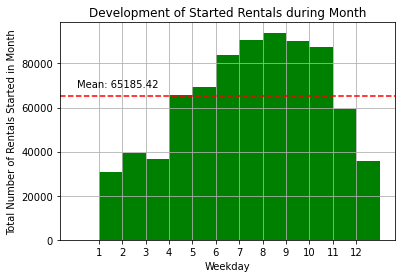

In [147]:
plt.hist(df["month"], bins=range(0,14,1), color="green")
plt.axhline(mean, color="r", linestyle="--")
plt.xlabel("Weekday")
plt.ylabel("Total Number of Rentals Started in Month")
plt.title("Development of Started Rentals during Month")
plt.xticks(range(1,13,1))
min_xlim, max_xlim = plt.xlim()
plt.text(min_xlim*(-0.1), mean*(1.06), "Mean: {:.2f}".format(mean))
plt.grid(True)
plt.show()

In [148]:
df_weather = df_weather_2017
df_weather["date"] = df_weather["date_time"].dt.date
df_weather["hour"] = df_weather["date_time"].dt.hour

#Join weather data with rental data and calculate average temperatures
df_merge = pd.merge(df, df_weather, how="left", left_on=["date", "hour"], right_on=["date", "hour"])
df_merge["avg_temp"] = df_merge[["max_temp", "min_temp"]].mean(axis="columns")

In [149]:
#Calculate average temperatures for each month
df_temp_month = df_merge.groupby("month")["avg_temp"].mean().reset_index(name="avg_temp")
df_temp_month

,month,avg_temp
0,1,5.119939
1,2,7.948301
2,3,7.608369
3,4,16.540951
4,5,18.157399
5,6,24.117792
6,7,26.453108
7,8,24.531805
8,9,22.156413
9,10,17.822924


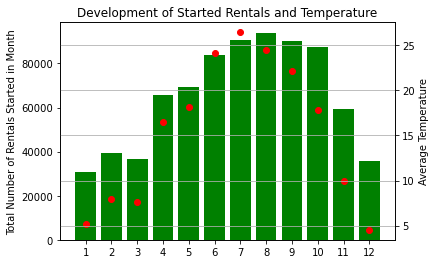

In [150]:
#Plot number of rentals together with average temperature
#Red dots would be the average temperature for each month
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
df_months = df.groupby(["month"])["month"].count().reset_index(name="n_of_retals_in_month")
ax1.bar(df_months["month"], df_months["n_of_retals_in_month"], color="green")
plt.xlabel("Weekday")
ax1.set_ylabel("Total Number of Rentals Started in Month")
plt.title("Development of Started Rentals and Temperature")
plt.xticks(range(1,13,1))
ax2.scatter(df_temp_month["month"], df_temp_month["avg_temp"], color="red")
ax2.set_ylabel("Average Temperature")
plt.grid(True)
plt.show()

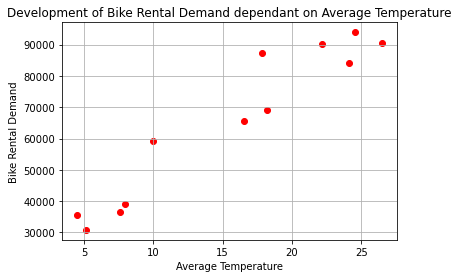

In [151]:
plt.scatter(df_temp_month["avg_temp"], df_months["n_of_retals_in_month"], color="red")
plt.xlabel("Average Temperature")
plt.ylabel("Bike Rental Demand")
plt.title("Development of Bike Rental Demand dependant on Average Temperature")
plt.grid(True)
plt.show()

##### Analysis and Interpretation of the Results:

The development of bike rental demand has similar development as the development of the average temperature during the year. 
The only difference can be seen at the peak. The average temperature has its peak in July whereas the bike rental demand has its peak in August. However, the difference in the bike rental demand in July and August is not that high. Another effect that could have an influence on the bike rental demand is the number of tourists. According to the annual report of Philadelphia, the number of tourists was the highest for the second and third quarters of the year (April to September). In these months the bike rental demand was always very close (April) or above the overall average of the bike rental demand. 
Especially for the month of December, January, February, and March the bike rental demand is clearly below the average.

Development of the tourist numbers according to the annual report: 
- Q1: 7 million
- Q2: 13.1 million
- Q3: 13.1 million
- Q4: 10.1 million

### Key Performance Indicators (KPIs)

#### Rental Durations

In [155]:
#Calculate the sum of rental durations for each month
#Calculate the average rental duration per rental for each month
df = df_philadelphia_cleaned
df_duration_monthly = df.groupby("month")["trip_duration"].sum().reset_index(name="sum_duration_bike_rentals")
df_duration_monthly["duration_in_hours"] = df_duration_monthly["sum_duration_bike_rentals"].dt.total_seconds().divide(60*60)
df_duration_monthly["duration_in_minutes"] = df_duration_monthly["sum_duration_bike_rentals"].dt.total_seconds().divide(60)
df_duration_monthly["number_of_rentals"] = df.groupby("month")["month"].count().reset_index(drop=True)
df_duration_monthly["avg_duration_per_rental_in_min"] = df_duration_monthly["duration_in_minutes"] / df_duration_monthly["number_of_rentals"]
df_duration_monthly

,month,sum_duration_bike_rentals,duration_in_hours,duration_in_minutes,number_of_rentals,avg_duration_per_rental_in_min
0,1,339 days 21:22:00,8157.366667,489442.0,30822,15.879631
1,2,484 days 06:14:00,11622.233333,697334.0,39189,17.794126
2,3,422 days 11:38:00,10139.633333,608378.0,36620,16.613271
3,4,922 days 15:44:00,22143.733333,1328624.0,65609,20.250636
4,5,935 days 03:52:00,22443.866667,1346632.0,69094,19.489854
5,6,1177 days 03:40:00,28251.666667,1695100.0,83967,20.187693
6,7,1287 days 06:23:00,30894.383333,1853663.0,90502,20.482011
7,8,1260 days 19:22:00,30259.366667,1815562.0,93941,19.326620
8,9,1188 days 20:32:00,28532.533333,1711952.0,90269,18.965005
9,10,1103 days 19:05:00,26491.083333,1589465.0,87315,18.203802


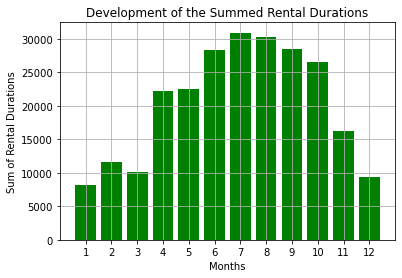

In [161]:
#Vizualize development of summed durations
plt.bar(df_duration_monthly["month"],
       df_duration_monthly["duration_in_hours"],
       color="green")
plt.grid(True)
plt.xticks(range(1,13,1))
plt.xlabel("Months")
plt.ylabel("Sum of Rental Durations")
plt.title("Development of the Summed Rental Durations")
plt.show()

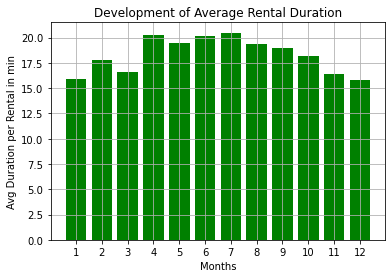

In [163]:
#Vizualize development of average durations for each month
plt.bar(df_duration_monthly["month"],
       df_duration_monthly["avg_duration_per_rental_in_min"],
       color="green")
plt.grid(True)
plt.xticks(range(1,13,1))
plt.xlabel("Months")
plt.ylabel("Avg Duration per Rental in min")
plt.title("Development of Average Rental Duration")
plt.show()

In [169]:
#Calculate the sum of rental durations for each week
#Calculate the average rental duration per rental for each week
df_duration_weekly = df.groupby("week")["trip_duration"].sum().reset_index(name="sum_duration_bike_rentals")
df_duration_weekly["duration_in_hours"] = df_duration_weekly["sum_duration_bike_rentals"].dt.total_seconds().divide(60*60)
df_duration_weekly["duration_in_minutes"] = df_duration_weekly["sum_duration_bike_rentals"].dt.total_seconds().divide(60)
df_duration_weekly["number_of_rentals"] = df.groupby("week")["week"].count().reset_index(drop=True)
df_duration_weekly["avg_duration_per_rental_in_min"] = df_duration_weekly["duration_in_minutes"] / df_duration_weekly["number_of_rentals"]
df_duration_weekly.head()

,week,sum_duration_bike_rentals,duration_in_hours,duration_in_minutes,number_of_rentals,avg_duration_per_rental_in_min
0,1,48 days 02:50:00,1154.833333,69290.0,4585,15.112323
1,2,77 days 11:52:00,1859.866667,111592.0,7084,15.752682
2,3,82 days 09:46:00,1977.766667,118666.0,8147,14.565607
3,4,89 days 12:36:00,2148.600000,128916.0,7641,16.871614
4,5,77 days 04:06:00,1852.100000,111126.0,8118,13.688840


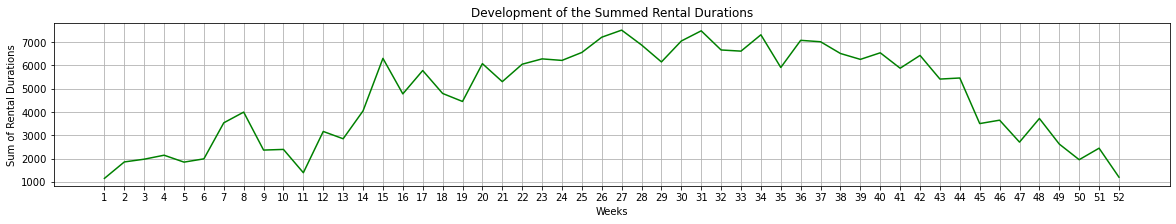

In [173]:
#Vizualize development of summed durations
plt.plot(df_duration_weekly["week"],
       df_duration_weekly["duration_in_hours"],
       color="green")
plt.grid(True)
plt.xticks(range(1,53,1))
plt.rcParams["figure.figsize"] = (50,3)
plt.xlabel("Weeks")
plt.ylabel("Sum of Rental Durations")
plt.title("Development of the Summed Rental Durations")
plt.show()

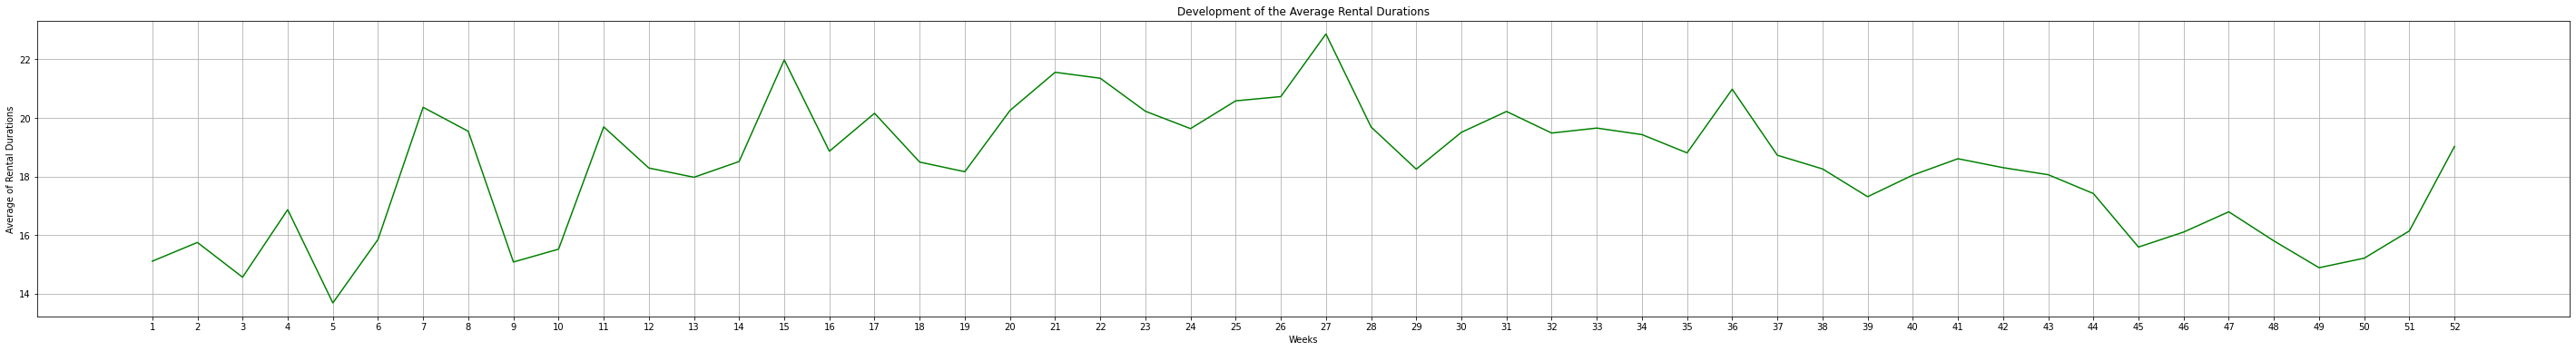

In [179]:
#Vizualize development of average durations for each week
plt.plot(df_duration_weekly["week"],
       df_duration_weekly["avg_duration_per_rental_in_min"],
       color="green")
plt.grid(True)
plt.xticks(range(1,53,1))
plt.rcParams["figure.figsize"] = (30,6)
plt.xlabel("Weeks")
plt.ylabel("Average of Rental Durations")
plt.title("Development of the Average Rental Durations")
plt.show()